In [1]:
import numpy as np
import pandas as pd
import tensorflow.keras as keras
from IPython.display import display
from tqdm import tqdm
from pathlib import Path

tqdm.pandas()

In [2]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style()
sns.set(rc={'figure.figsize':(11.7,8.27)})

from plotly import __version__
get_ipython().run_line_magic('matplotlib', 'inline')
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly_express as px
init_notebook_mode(connected=True)

cf.go_offline()

In [3]:
df = pd.read_csv(Path('data/jigsaw-toxic-comment-classification-challenge-2018/train.csv'))
df = df.head(10**4)
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
9995,1a790ff1007a10e3,Numbers may be either listed separately at the...,0,0,0,0,0,0
9996,1a7a4868968e2b9e,"Those two love to disagree, don't they? 206.17...",0,0,0,0,0,0
9997,1a7c3bec9a71415d,"""I have changed """"Lance Thomas"""" to """"Lance Th...",0,0,0,0,0,0
9998,1a7c9c14b0cf0fe0,states \n\nCourts: I have been putting all art...,0,0,0,0,0,0


In [4]:
df.select_dtypes('number').apply(lambda x: x.sum() / x.shape[0] * 100)

toxic            9.71
severe_toxic     1.01
obscene          5.27
threat           0.33
insult           4.94
identity_hate    0.84
dtype: float64

In [5]:
import nltk, re, string

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('\s+', ' ', text)
    return text


def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    combined_text = ' '.join(tokenized_text)
    return combined_text

In [6]:
df['text_clean'] = df['comment_text'].progress_apply(
    lambda x: text_preprocessing(x)
)

df['word_count'] = df['text_clean'].progress_apply(
    lambda x: len(str(x).split())
)

labels = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
df['labels'] = df[labels].progress_apply(
    lambda x: ','.join([l for k, l in enumerate(labels) if x[k] == 1]),
    axis=1
)
display(df['labels'].unique())

df.head()

100%|██████████| 10000/10000 [00:01<00:00, 7546.26it/s]


array(['', 'toxic,severe_toxic,obscene,insult', 'toxic',
       'toxic,obscene,insult,identity_hate', 'toxic,obscene,insult',
       'toxic,obscene', 'toxic,threat', 'toxic,insult',
       'toxic,obscene,threat,insult,identity_hate', 'insult', 'obscene',
       'toxic,severe_toxic,obscene', 'toxic,obscene,threat,insult',
       'toxic,severe_toxic,obscene,insult,identity_hate',
       'toxic,severe_toxic,obscene,threat,insult,identity_hate',
       'toxic,insult,identity_hate', 'toxic,identity_hate',
       'obscene,insult', 'toxic,severe_toxic,obscene,identity_hate',
       'toxic,severe_toxic,obscene,threat,insult', 'identity_hate',
       'toxic,obscene,identity_hate', 'threat',
       'obscene,insult,identity_hate', 'toxic,severe_toxic',
       'toxic,severe_toxic,insult', 'toxic,severe_toxic,identity_hate',
       'obscene,threat', 'toxic,threat,insult', 'insult,identity_hate',
       'toxic,severe_toxic,obscene,threat',
       'toxic,severe_toxic,insult,identity_hate', 'toxic,obs

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,text_clean,word_count,labels
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation why the edits made under my userna...,46,
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,d aww he matches this background colour i m se...,16,
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man i m really not trying to edit war it s...,44,
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,more i can t make any real suggestions on impr...,116,
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,you sir are my hero any chance you remember wh...,14,


In [7]:
df['text_clean'].loc[df['word_count'].sort_values().index[:10]]

4482             
6890             
9919             
2748             
6300             
6193             
9712        check
5899    copyright
6233       thanks
1217       august
Name: text_clean, dtype: object

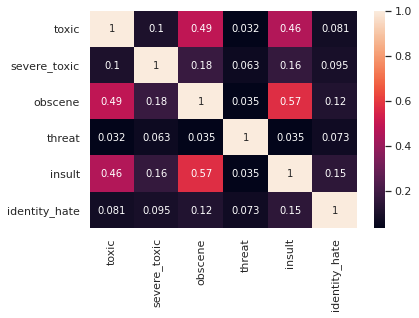

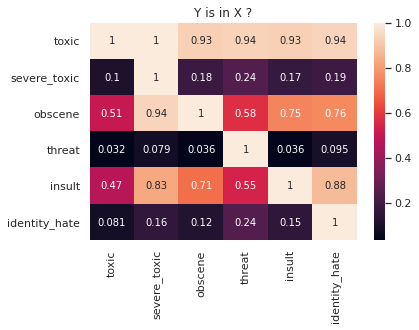

In [8]:
from scipy.spatial import distance

jaccard = df[labels].corr(
    lambda x, y: 1-distance.jaccard(x, y)
)
inside = np.zeros((len(labels), len(labels)))
for i, ac in enumerate(df[labels]):
    for j, bc in enumerate(df[labels]):
        a = df[ac]
        b = df[bc]
        inside[i,j] = a[b==1].sum() / b.sum()
inside = pd.DataFrame(inside, columns=labels, index=labels)

plt.figure()
sns.heatmap(jaccard, annot=True);
plt.figure()
sns.heatmap(inside, annot=True).set_title('Y is in X ?');

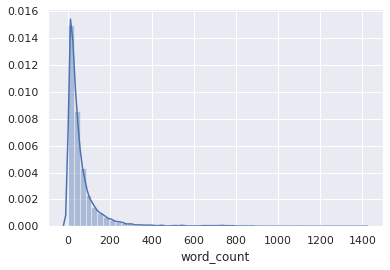

In [9]:
sns.distplot(df['word_count']);

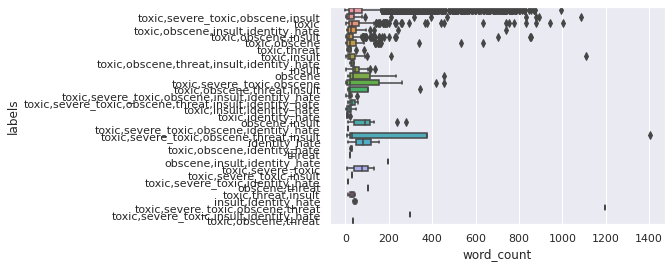

In [10]:
sns.boxplot(df['word_count'], df['labels']);

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

def get_ngram(corpus:pd.Series, n):
    vec = CountVectorizer(ngram_range=(n,n), stop_words='english')
    bow = vec.fit_transform(corpus)
    count = bow.sum(axis=0)
    word_freq = pd.Series({k:count[0,v] for k,v in vec.vocabulary_.items()})
    return word_freq.sort_values(ascending=False)

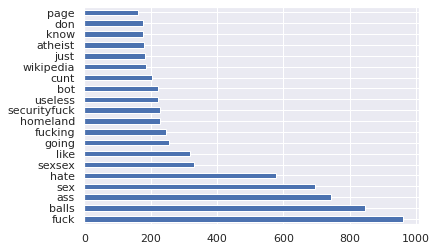

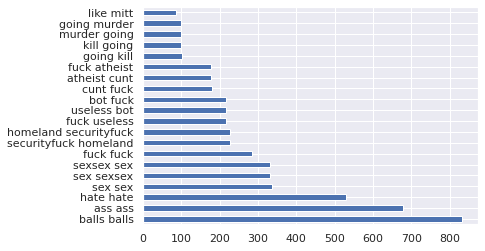

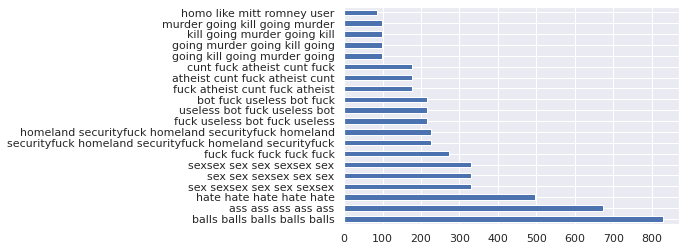

In [12]:
corpus = df.query("labels!=''")['text_clean']

plt.figure()
get_ngram(corpus, 1).iloc[:20].plot(kind='barh');
plt.figure()
get_ngram(corpus, 2).iloc[:20].plot(kind='barh');
plt.figure()
get_ngram(corpus, 5).iloc[:20].plot(kind='barh');

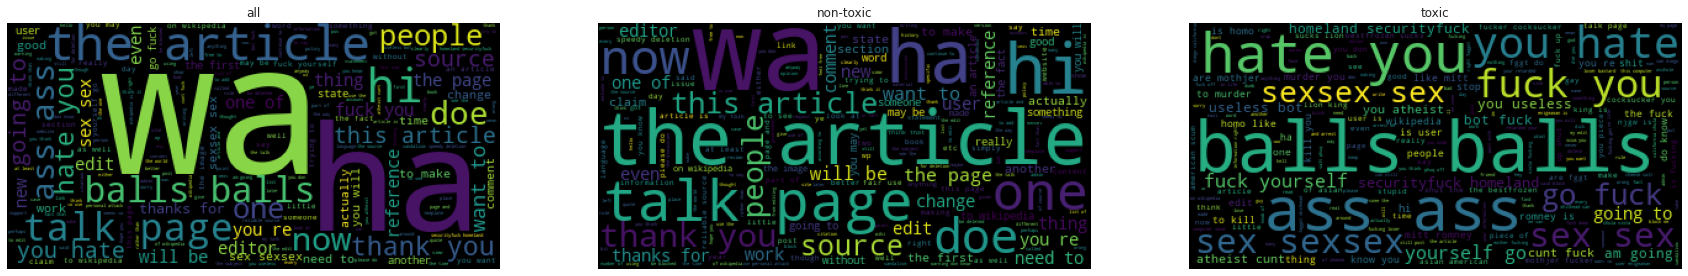

In [13]:
from wordcloud import WordCloud

fig, ax = plt.subplots(1,3, figsize=[30,15])

def make_wordcloud(ax:plt.Axes, corpus, title, collocations=True):
    wc = WordCloud(collocations=collocations).generate(' '.join(corpus))
    ax.imshow(wc)
    ax.axis('off')
    ax.set_title(title)

make_wordcloud(ax[0], df['text_clean'], 'all')
make_wordcloud(ax[1], df.query('labels==""')['text_clean'], 'non-toxic')
make_wordcloud(ax[2], df.query('labels!=""')['text_clean'], 'toxic')

 ## RoBERTa model

In [14]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained(
        'roberta-base',
        do_lower_case=True
)

In [15]:
df['tokens'] = df['comment_text'].progress_apply(
    lambda x: tokenizer.tokenize(str(x))
)

100%|██████████| 10000/10000 [00:09<00:00, 1108.75it/s]


In [16]:
def tokenize(sentences, tokenizer):
    input = None
    for sentence in tqdm(sentences):
        t = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=128,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_token_type_ids=True
        )

        if input is None:
            input = {k:np.array(v, dtype='int32') for k,v in t.items()}
        else:
            input = {k:np.append(v, t[k]) for k,v in input.items()}
    return input

In [17]:
input = tokenize(df['comment_text'], tokenizer)
display(input)

100%|██████████| 10000/10000 [00:43<00:00, 230.16it/s]


{'input_ids': array([    0,  8257, 50118, ...,     1,     1,     1]),
 'token_type_ids': array([0, 0, 0, ..., 0, 0, 0]),
 'attention_mask': array([1, 1, 1, ..., 0, 0, 0])}

## Pre-trained model

In [ ]:
import tensorflow as tf
from transformers import TFRobertaForSequenceClassification, RobertaConfig

config = RobertaConfig()